In [1]:
%matplotlib inline
import lightkurve as lk
from lightkurve_ext import download_lightcurvefiles
import tic_plot as tplt

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib

import pandas as pd
import astropy as astropy
from astropy.io import fits

In [2]:
# Possible Candidates, not a TOI yet
# the dips look a tad V-shape though.
tic1 = 232612416

# Load the light_curves into collection
lcf_coll = download_lightcurvefiles(f"TIC{tic1}", mission='TESS', download_dir='./data')
print(len(lcf_coll))


2


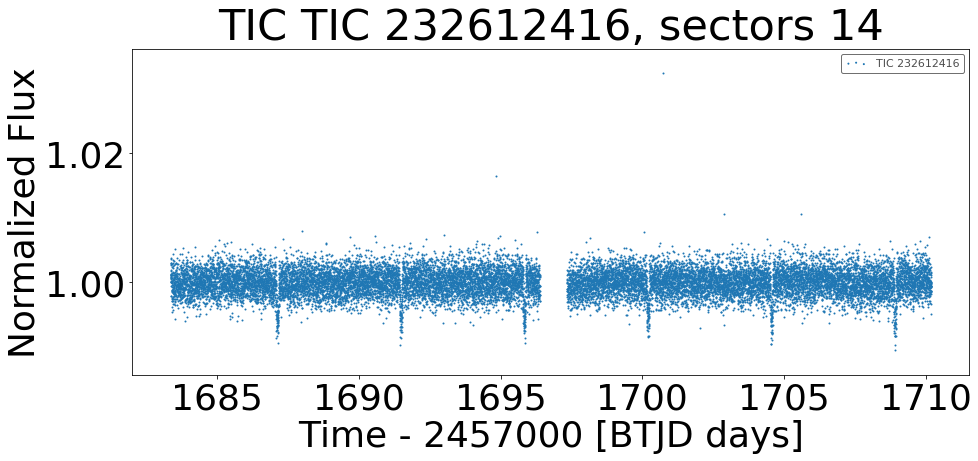

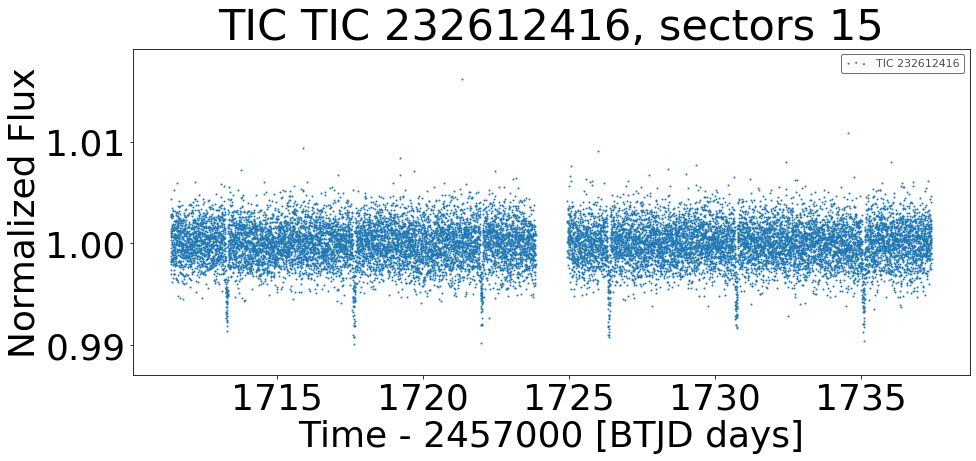

In [3]:
tplt.plot_all(lcf_coll)

In [4]:
if False: 
    fig = plt.figure(figsize=(30,15))
    tplt.plot_lcf_flux_delta(tplt.lcf_of_sector(lcf_coll, 15), fig.gca()
                     , xmin=1734.5, xmax=1735.5
                       )


Sectors: [14, 15]


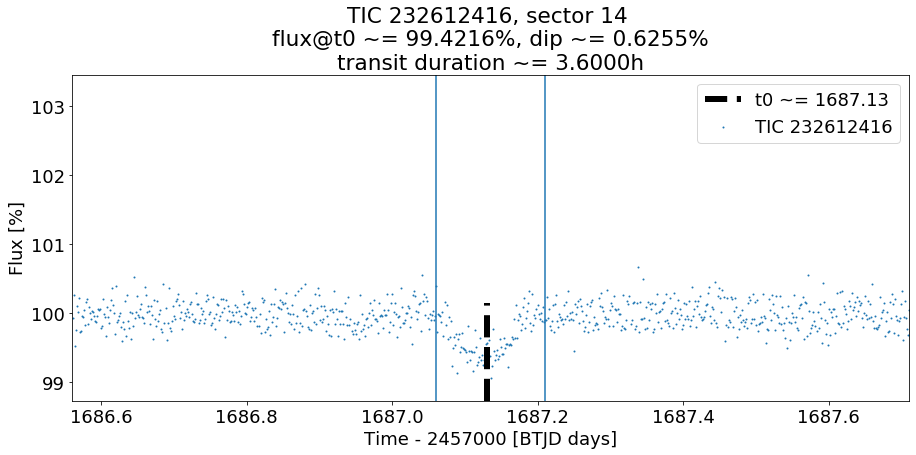

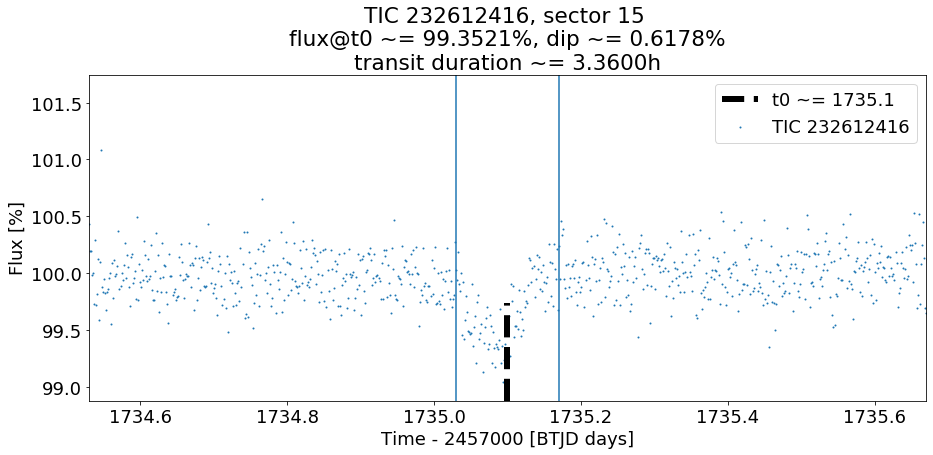

In [5]:
def plot_selected(lcf_coll):                      
    matplotlib.rcParams.update({'font.size':18}) 
    matplotlib.rcParams.update({'font.family':'sans-serif'})
    ax = tplt.plot_n_annotate_lcf(tplt.lcf_of_sector(lcf_coll, 14), ax=tplt.lcf_fig().gca()
                        , t0=1687.13, t_start=1687.06, t_end=1687.21
#                         , t0=1704.58, t_start=1704.51, t_end=1704.65
                       )
    tplt.plot_n_annotate_lcf(tplt.lcf_of_sector(lcf_coll, 15), ax=tplt.lcf_fig().gca()
                        , t0=1735.10, t_start=1735.03, t_end=1735.17
                       )
#     print(f"Period ~= {as_4decimal(1622.5 - 1538.6)} days")
    return 

plot_selected(lcf_coll)

print("Sectors: " + str(list(map(lambda lcf: lcf.header()['SECTOR'], lcf_coll))))


In [6]:
# show more properties of one lightcurve

print(list(map(lambda lc: lc.header()['SECTOR'], lcf_coll)))
print(list(map(lambda lc: lc.header()['CAMERA'], lcf_coll)))
print(list(map(lambda lc: lc.header()['DATE-OBS'], lcf_coll)))

lcf14 = tplt.lcf_of_sector(lcf_coll, 14)
lc14 = lcf14.PDCSAP_FLUX.normalize(unit='percent')

lc14.show_properties()

# noise estimates
# transit_duration=90, 90 cadence, roughly 3 hours with in data with 2-min cadence
print (f"CDPP: {lc14.estimate_cdpp(transit_duration=90)}")
print (f"CDPP - flatten: {lc14.flatten().estimate_cdpp(transit_duration=90)}")
print (f"CDPP - remove outlines: {lc14.remove_outliers().estimate_cdpp(transit_duration=90)}")



[14, 15]
[3, 3]
['2019-07-18T20:19:29.942Z', '2019-08-15T20:35:28.889Z']
   Attribute               Description           
--------------- ---------------------------------
       targetid                         232612416
          label                     TIC 232612416
        mission                              TESS
quality_bitmask                           default
    time_format                              btjd
     time_scale                               tdb
      cadenceno                    array (18522,)
   centroid_col                    array (18522,)
   centroid_row                    array (18522,)
           flux                    array (18522,)
       flux_err                    array (18522,)
  flux_quantity                    array (18522,)
        quality                    array (18522,)
           time                    array (18522,)
   astropy_time  <class 'astropy.time.core.Time'>
         camera                <class 'NoneType'>
            ccd            

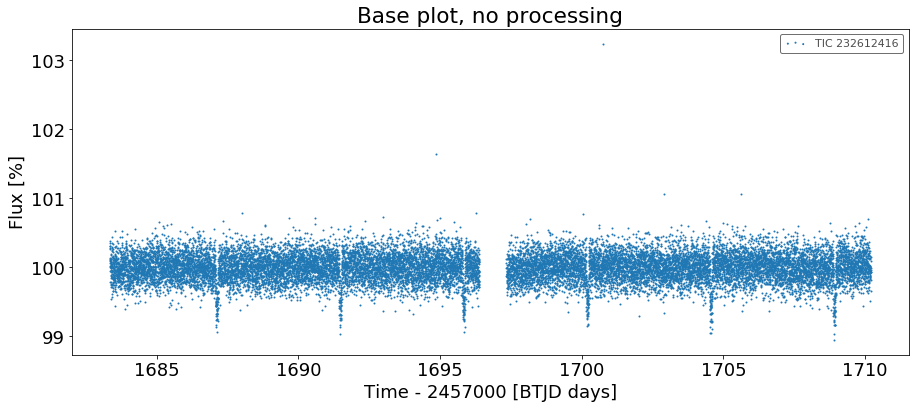

In [7]:
def newplot(title):
    fig = plt.figure(figsize=(15, 6))
    fig.gca().set_title(title)
    return fig

fig = newplot('Base plot, no processing')
lc14.scatter(ax=fig.gca())


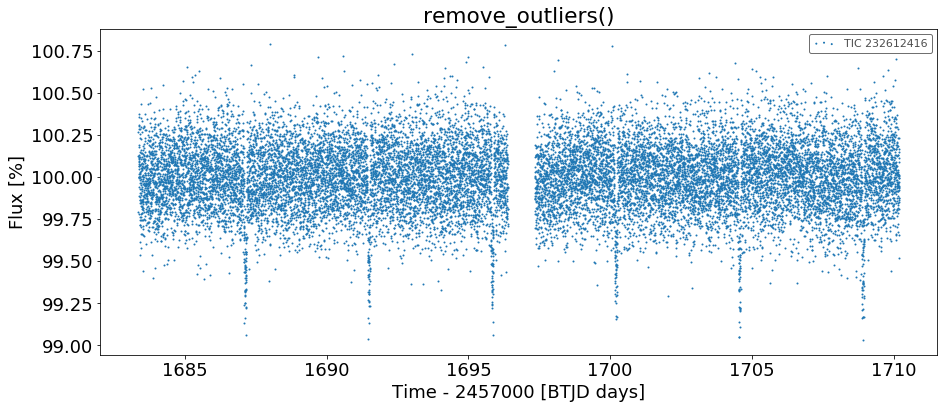

In [8]:
# default 5 sigma seems to be okay
fig = newplot('remove_outliers()')
lc14.remove_outliers().scatter(ax=fig.gca())


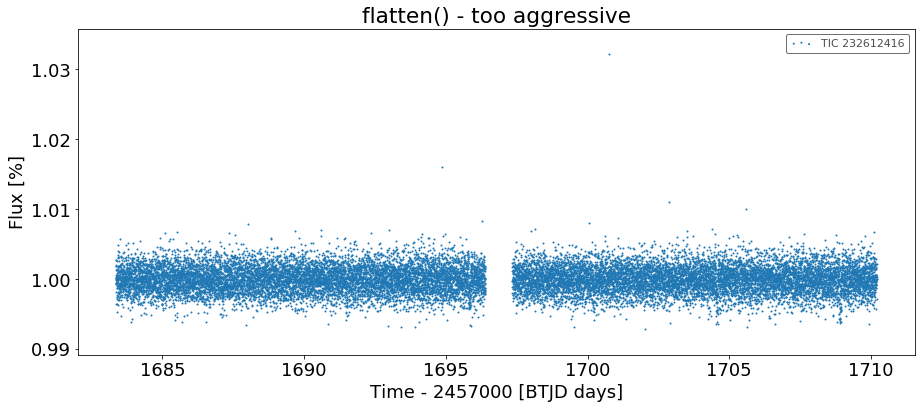

In [9]:
fig = newplot('flatten() - too aggressive')
lc14.flatten().scatter(ax=fig.gca())


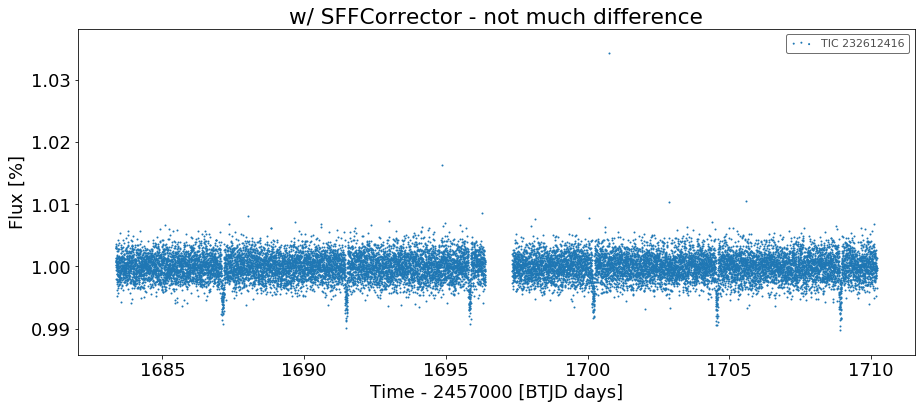

In [10]:
corrector = lc14.to_corrector(method='sff') # SFFCorrector
lc_corr = corrector.correct()
fig = newplot('w/ SFFCorrector - not much difference')
lc_corr.scatter(ax=fig.gca())


Text(0.5, 1.0, 'Centroids')

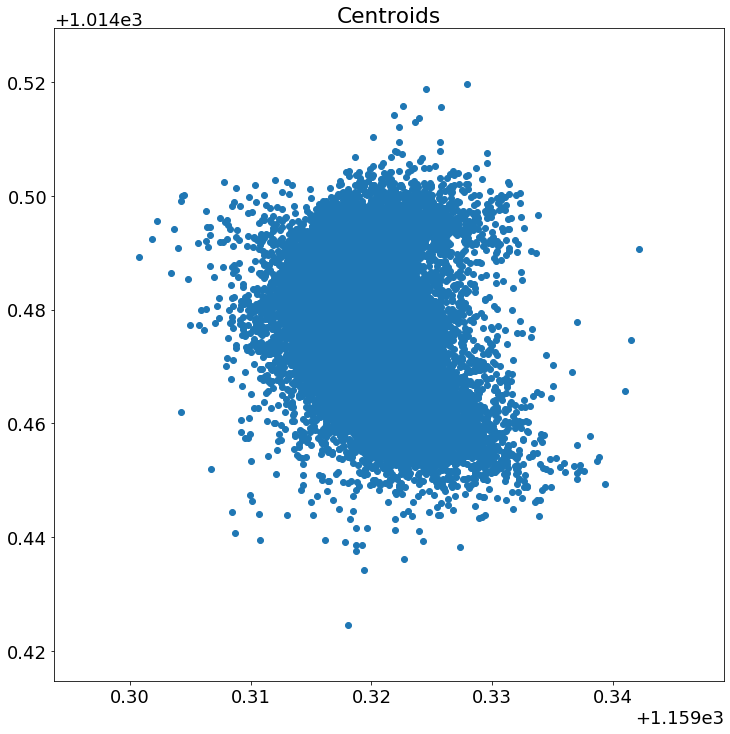

In [11]:
# SFFCorrector relies on centroid, show centroid

fig = plt.figure(figsize=(12,12))
fig.gca().scatter(lc14.centroid_col, lc14.centroid_row)
fig.gca().set_title('Centroids')


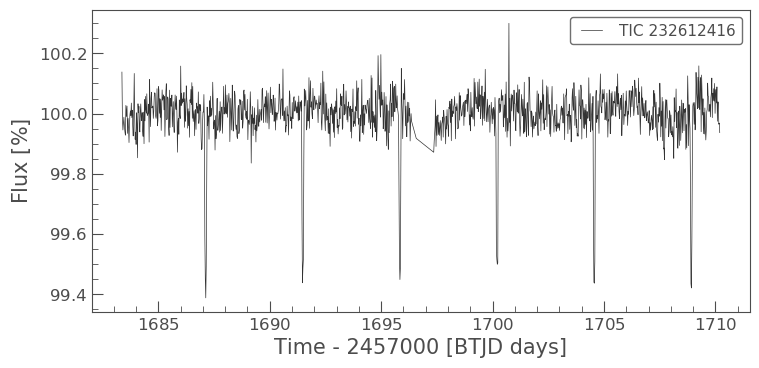

In [12]:
# binsize 15 is approximately half an hour, so it's roughly the same as mooving average of 30minues
lc14.bin(binsize=15).plot(title="Binned, size=15")


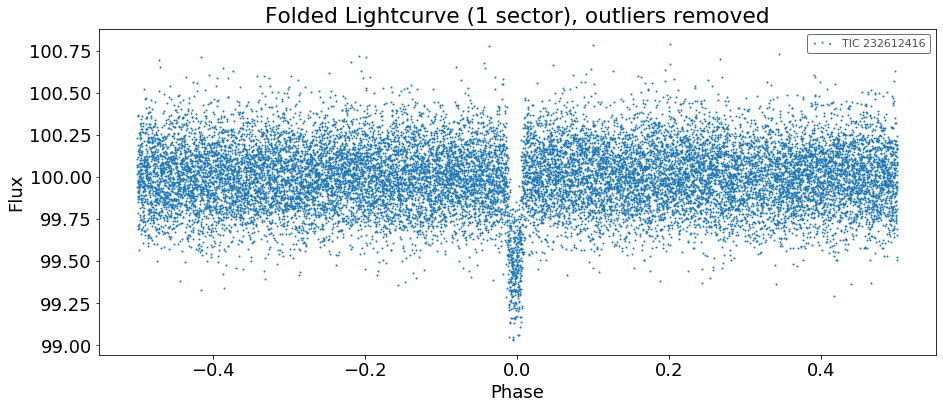

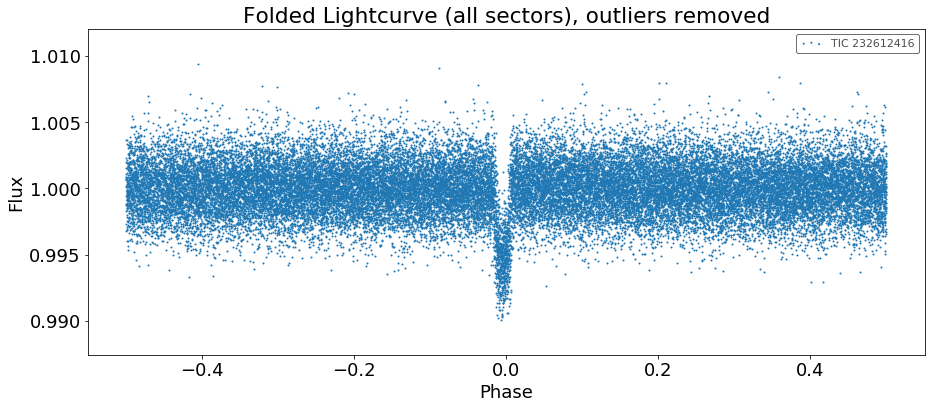

In [13]:
fig = newplot('Folded Lightcurve (1 sector), outliers removed')
# t0, period by eyeballing the lightcurve
t0 = 1687.13
period = 4.3625
lc14.remove_outliers().fold(period, t0=t0).scatter(ax=fig.gca())

fig = newplot('Folded Lightcurve (all sectors), outliers removed')
lcf_coll.PDCSAP_FLUX.stitch().normalize().remove_outliers().fold(period, t0=t0).scatter(ax=fig.gca())


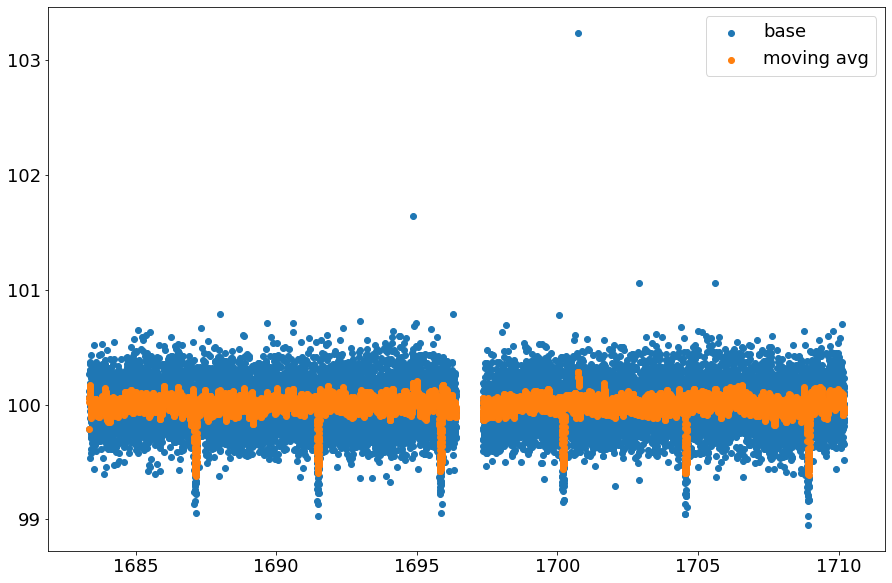

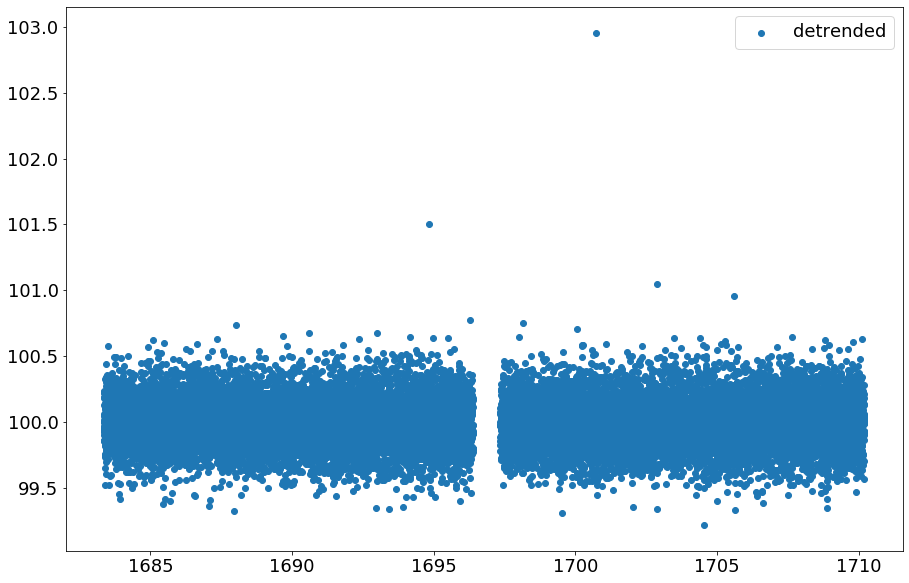

In [14]:
# Detrending, with moving average as the fit
# - based on https://oldtalk.planethunters.org/science/discussions/DPH100ht7b

df14_ma = tplt.add_flux_moving_average(lc14, '30min')
df14_ma['flux_detrended'] = df14_ma['flux'] - df14_ma['flux_mavg'] + 100.0

# OPEN: I am not quite sure how to interpret / use detrended flux 
if True:
    plt.figure(figsize=(15,10))
    plt.scatter(df14_ma['time'], df14_ma['flux'], label="base")
    plt.scatter(df14_ma['time'], df14_ma['flux_mavg'], label="moving avg")
    plt.legend()
    plt.figure(figsize=(15,10))
    plt.scatter(df14_ma['time'], df14_ma['flux_detrended'], label='detrended')
    plt.legend()



In [15]:
# show details of one dip
df14 = lcf14.PDCSAP_FLUX.normalize(unit='percent').to_pandas(columns=['time', 'flux', 'centroid_row', 'centroid_col'])
df14[(df14.time >= 1704.51) & (df14.time <= 1704.65)]


,time,flux,centroid_row,centroid_col
time,,,,
1704.510711,1704.510711,100.297104,1014.468251,1159.323003
1704.512100,1704.512100,99.946114,1014.464733,1159.321232
1704.513489,1704.513489,99.970741,1014.469815,1159.321004
1704.514878,1704.514878,99.970367,1014.465347,1159.320650
1704.516267,1704.516267,99.610306,1014.465216,1159.322860
1704.517656,1704.517656,100.089714,1014.469085,1159.317134
1704.519044,1704.519044,100.101341,1014.470644,1159.328215
1704.520433,1704.520433,99.731033,1014.469600,1159.317680
1704.521822,1704.521822,99.836227,1014.462837,1159.316042


In [16]:
print("Sector Observation time range:")
for i in range(0, len(lcf_coll)):
    lc_cur = lcf_coll[i].get_lightcurve('PDCSAP_FLUX')
    print(f"  Sector {lcf_coll[i].header()['SECTOR']}: {lc_cur.time.min()} - {lc_cur.time.max()}")

# use the interactive transit period detection
#   caveat: un-sure if combining observations over time make sense for the algorithm
lcf_coll.PDCSAP_FLUX.stitch().interact_bls()


Sector Observation time range:
  Sector 14: 1683.3539902856278 - 1710.203717809407
  Sector 15: 1711.3648177619948 - 1737.4090389734008
